<a href="https://colab.research.google.com/github/claudiocamolese/LLM-Foundation-Model/blob/main/Deepseek.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
%%capture
!pip install -U transformers bitsandbytes
!pip install -U "huggingface_hub[cli]"

In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, BitsAndBytesConfig, GenerationConfig, TextStreamer, pipeline, Pipeline
from huggingface_hub import login
import torch
from logging import raiseExceptions
import time as t
from transformers import BitsAndBytesConfig
import matplotlib.pyplot as plt
import numpy as np
from google.colab import userdata
import gc, psutil
import os
import sys
import torch.nn.functional as F


quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float32,  # usa float16 anche per il calcolo
)

login(token=userdata.get('hugging_face'))
generator_model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"
summirizer_model_name = "Qwen/Qwen2-0.5B"
similarity_model_name = "sentence-transformers/all-MiniLM-L6-v2"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Classes

In [3]:
class BaseModel:

    def __init__(self, model_name, quantization_config, device):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.device = device

        self.model = AutoModelForCausalLM.from_pretrained(
            self.model_name,
            quantization_config=self.quantization_config,
            device_map=self.device,
            use_cache=False
        )

        self.tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")

    def forget_all(self):
        # Gestisci il modello in modo difensivo
        if self.model is not None:
            try:
                # Lista di attributi comuni di cache da ripulire
                cache_attrs = ["cache", "kv_cache", "past_key_values", "attention_mask",
                            "key_value_memory_cache", "memory", "buffer"]

                # Pulisci attributi senza usare dir()
                for attr in cache_attrs:
                    try:
                        if hasattr(self.model, attr):
                            setattr(self.model, attr, None)
                    except:
                        pass

                # Metodi comuni di pulizia cache
                clean_methods = ["clear_cache", "reset_cache", "empty_cache", "free_memory"]
                for method in clean_methods:
                    try:
                        if hasattr(self.model, method) and callable(getattr(self.model, method)):
                            getattr(self.model, method)()
                    except:
                        pass
            except:
                pass

            # Forza il modello a None
            self.model = None

        # Gestisci il tokenizer in modo difensivo
        if self.tokenizer is not None:
            try:
                # Attributi comuni di cache del tokenizer
                tokenizer_cache_attrs = ["cache", "encoder_cache", "decoder_cache"]
                for attr in tokenizer_cache_attrs:
                    try:
                        if hasattr(self.tokenizer, attr):
                            setattr(self.tokenizer, attr, None)
                    except:
                        pass
            except:
                pass

            # Forza il tokenizer a None
            self.tokenizer = None

        # Libera memoria CUDA
        try:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
                try:
                    torch.cuda.ipc_collect()
                except:
                    pass
        except:
            pass

In [4]:
class GeneratorModel(BaseModel):

    def __init__(self, model_name, quantization_config, device):
        super().__init__(model_name, quantization_config, device)

    def first_generate(self, prompt, do_sample=False, max_new_tokens=30000):

        start = t.time()

        messages = [
            {"role": "system", "content": "You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop."},
            {"role": "user", "content": prompt}
        ]

        try:
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                do_sample=do_sample
            )

            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.device)
            streamer = TextStreamer(self.tokenizer, skip_special_tokens=True)

            # Generate text
            generated_ids = self.model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                streamer=streamer
            )

            # Process the generated tokens to get the new part only
            processed_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]

            response = self.tokenizer.batch_decode(processed_ids, skip_special_tokens=True)[0]
            counter = len(self.tokenizer.encode(response))

            perplexity = self.calculate_perplexity(response)
            end = t.time()

            return response, counter, perplexity, end-start

        finally:
            # Only attempt cleanup if model and tokenizer were initialized
            if self.model is not None and self.tokenizer is not None:
                self.forget_all()

    def n_generate(self, prompt, summary, max_new_tokens=800, do_sample=False):
        start = t.time()

        messages = [
            {"role": "system", "content": (
                "You are a summarization assistant. "
                "Your task is to output only the final summary of the user's message, "
                "in one concise sentence. "
                "Do NOT include any explanation, inner thoughts, or <think> tags. "
                "Do NOT describe what you're doing. Just return the summary directly, nothing else."
            )},
            {"role": "user", "content": "prompt: " + prompt + "summary: " + summary}
        ]

        try:
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True,
                do_sample=do_sample
            )

            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.device)
            streamer = TextStreamer(self.tokenizer, skip_special_tokens=True)

            generated_ids = self.model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                streamer=streamer
            )

            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]

            response = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            counter = len(self.tokenizer.encode(response))
            perplexity = self.calculate_perplexity(response)
            end = t.time()

            return end-start, response, counter, perplexity
        finally:
            # Clean up everything even if an error occurs
            # self.forget_all()
            pass

    def calculate_perplexity(self, text):
        """Calculate the perplexity of the generated text."""

        try:
            # Encode the text
            encodings = self.tokenizer(text, return_tensors="pt").to(self.device)

            # Create a labels tensor that's a copy of the input_ids
            labels = encodings.input_ids.clone()

            # Forward pass with labels for loss calculation
            with torch.no_grad():
                outputs = self.model(**encodings, labels=labels)

            # Get the loss
            neg_log_likelihood = outputs.loss.item()

            # Calculate perplexity: exp(loss)
            # Loss is already the mean negative log-likelihood
            perplexity = torch.exp(torch.tensor(neg_log_likelihood)).item()

            return perplexity

        except Exception as e:
            print(f"Error calculating perplexity: {e}")
            return float('nan')


In [5]:
class SummarizerModel(BaseModel):
    def __init__(self, model_name, quantization_config, device):
        # Riutilizza l'inizializzazione di BaseModel
        super().__init__(model_name, quantization_config, device)

    def truncated(self, input_string, n_tokens):
        """Truncate the input string to a specific number of tokens."""

        try:
            tokens = self.tokenizer.encode(input_string)  # Usa self.tokenizer ereditato da BaseModel
            truncated_tokens = tokens[:n_tokens]
            truncated_string = self.tokenizer.decode(truncated_tokens, skip_special_tokens=True)
            return truncated_string
        except Exception as e:
            print(f"Error truncating string: {e}")
            return input_string[:100]  # Fallback to simple string slicing

    def summarize(self, text, max_new_tokens=800):
        """Generate a summary of the provided text."""

        messages = [
            {"role": "system", "content": "You are a helpful assistant that summarizes content concisely."},
            {"role": "user", "content": f"Please summarize the following text:\n\n{text}"}
        ]

        try:
            formatted_text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )

            model_inputs = self.tokenizer([formatted_text], return_tensors="pt").to(self.device)
            streamer = TextStreamer(self.tokenizer, skip_special_tokens=True)

            generated_ids = self.model.generate(
                **model_inputs,
                max_new_tokens=max_new_tokens,
                streamer=streamer
            )

            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]

            summary = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            counter = len(self.tokenizer.encode(summary))

            return summary, counter
        except Exception as e:
            print(f"Error generating summary: {e}")
            return "Error generating summary", 0

In [6]:
class SentenceSimilarity:
    def __init__(self, model_name,  quantization_config, device):
        self.model_name = model_name
        self.quantization_config = quantization_config
        self.device = device

        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModel.from_pretrained(self.model_name).to(self.device)
        self.model.eval()

    def get_embeddings(self, sentence):
        # Tokenizza e calcola gli embedding
        inputs = self.tokenizer(sentence, padding=True, truncation= False, return_tensors="pt").to(self.device)
        with torch.no_grad():
            outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # Media dei token
        return embeddings

    def compute_similarity(self, sentence1, sentence2):
        # Funzione che accetta esattamente due frasi
        emb1 = self.get_embeddings([sentence1])
        emb2 = self.get_embeddings([sentence2])
        cosine_sim = F.cosine_similarity(emb1, emb2)
        return np.float16(cosine_sim.item())  # Restituisce un float



In [7]:
def free_gpu_memory():
    # MODEL
    try:
        model.forget_all()
    except Exception as e:
        print(f"Failed to run model.forget_all(): {e}")
    try:
        del model
    except Exception as e:
        print(f"Failed to delete model: {e}")

    # TOKENIZER
    try:
        tokenizer.forget_all()
    except Exception as e:
        print(f"Failed to run tokenizer.forget_all(): {e}")
    try:
        del tokenizer
    except Exception as e:
        print(f"Failed to delete tokenizer: {e}")

    # SUMMARIZER
    try:
        summarizer.forget_all()
    except Exception as e:
        print(f"Failed to run summarizer.forget_all(): {e}")
    try:
        del summarizer
    except Exception as e:
        print(f"Failed to delete summarizer: {e}")

    # Garbage collection
    gc.collect()

    # Clear GPU cache if available
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def pretty_print(text: str):
    line = '-' * len(text)
    print(f"{line}\n{text}\n{line}")

In [16]:
free_gpu_memory()
model = GeneratorModel(model_name=generator_model_name, quantization_config=quantization_config, device=device)
summarizer = SummarizerModel(model_name=summirizer_model_name, quantization_config=quantization_config, device=device)
similarity_model = SentenceSimilarity(model_name= similarity_model_name, quantization_config=quantization_config, device=device)

Failed to run model.forget_all(): cannot access local variable 'model' where it is not associated with a value
Failed to delete model: cannot access local variable 'model' where it is not associated with a value
Failed to run tokenizer.forget_all(): cannot access local variable 'tokenizer' where it is not associated with a value
Failed to delete tokenizer: cannot access local variable 'tokenizer' where it is not associated with a value
Failed to run summarizer.forget_all(): cannot access local variable 'summarizer' where it is not associated with a value
Failed to delete summarizer: cannot access local variable 'summarizer' where it is not associated with a value


# Validation

In [13]:
dataset = [
          # "\int t^3-\frac{e^{-t}-4}{e^{-t}} dt",
            "Solve this differential equation y′ − 2y = 1",
          #  "Solve this differential equation y′ + y = e^x",
          #  "Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5",
          # "Using the Laplace transform find the solution for the following equation (\frac{\partial }{\partial t} y(t)) + y(t)= f(t) with initial conditions y(0)=a, Dy(0)=b",
          # "Compute the Fourier trasformation of x(t)=\frac{1}{(t-a)(t-b)} with a,b \in \mathbb{R}, a \neq b",
          # "Evaluate \int \int_{D} (x+2y)dA, where D is the regiond bounded by the parabolas y=2x^2 and y=1+x^2", #3000 tokens
          # "Find the Taylor series of the following functions and their radii of convergence: z \dot sinh(z^2) at z=0", #2000 tokens
          # "Using Cauchy's Residue Theorem, evaluate \int_{C} \frac{z-1}{(z-1)^2(z-2)} where C is |z-i|=2", #-2pi i
          # "Compute the limit \lim_{x \to 0^+} (1+e^{\frac{1}{x^3}})^{sin(x)}" #2996, infinty
           ]



In [14]:
def validate(prompt, iter, model = model, summarizer = summarizer, max_tokens_response = 500, max_tokens_summary = 200):

  start = t.time()
  iter_counter = {}
  similarity = 0
  old_summary = ""
  i=1

  while not np.isclose(similarity, 1, 0.2):

    pretty_print(f">>>>>>>>>>>>>>>>>>>>>>>>> Inizio iterazione: {i} <<<<<<<<<<<<<<<<<<<<<<<<<")


    pretty_print("Response: ")
    timer, response, counter, perplexity = model.n_generate(prompt = prompt, summary = old_summary, max_new_tokens = max_tokens_response)
    print("--------------")
    print("Counter: ", counter)
    iter_counter[f"iteration {i}"]={"tokens": counter, "perplexity" : perplexity}


    pretty_print("Summary:")
    summary, counter = summarizer.summarize(summarizer.truncated(response, n_tokens=200), max_new_tokens=max_tokens_summary)
    iter_counter[f"iteration {i}"]=counter
    similarity = similarity_model.compute_similarity(old_summary, summary)
    pretty_print(f"Similarity is: {similarity}")
    old_summary = summary
    end= t.time()
    i +=1

  model.forget_all()
  summarizer.forget_all()

  return end-start, iter_counter

In [ ]:
validate("\int t^3-\frac{e^{-t}-4}{e^{-t}} dt", 4)

# Functions

In [ ]:
def initialize_model(model_name ,quantization_config= quantization_config, device=device):
    id_models=set()

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        device_map=device,
        use_cache=False,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name, padding=True, padding_side = "left")

    print(f"New model initialized - ID: {id(model)}")

    if id(model) in id_models:
      raiseExceptions("Model already initialized")
    else:
      id_models.add(id(model))
    return model, tokenizer

def forget_all(model=None, tokenizer=None):

    # Gestisci il modello in modo difensivo
    if model is not None:
        try:
            # Lista di attributi comuni di cache da ripulire
            cache_attrs = ["cache", "kv_cache", "past_key_values", "attention_mask",
                          "key_value_memory_cache", "memory", "buffer"]

            # Pulisci attributi senza usare dir()
            for attr in cache_attrs:
                try:
                    if hasattr(model, attr):
                        setattr(model, attr, None)
                except:
                    pass

            # Metodi comuni di pulizia cache
            clean_methods = ["clear_cache", "reset_cache", "empty_cache", "free_memory"]
            for method in clean_methods:
                try:
                    if hasattr(model, method) and callable(getattr(model, method)):
                        getattr(model, method)()
                except:
                    pass
        except:
            pass

        # Forza il modello a None
        model = None

    # Gestisci il tokenizer in modo difensivo
    if tokenizer is not None:
        try:
            # Attributi comuni di cache del tokenizer
            tokenizer_cache_attrs = ["cache", "encoder_cache", "decoder_cache"]
            for attr in tokenizer_cache_attrs:
                try:
                    if hasattr(tokenizer, attr):
                        setattr(tokenizer, attr, None)
                except:
                    pass
        except:
            pass

        # Forza il tokenizer a None
        tokenizer = None

    # Libera memoria CUDA
    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            try:
                torch.cuda.ipc_collect()
            except:
                pass
    except:
        pass

    # Garbage collection
    try:
        gc.collect(generation=2)
    except:
        gc.collect()

    # Su Linux, prova a liberare memoria extra
    try:
        if sys.platform.startswith('linux'):
            os.system('sync')
    except:
        pass

    # Garbage collection finale
    gc.collect()

    return True

def first_generate(prompt, model_name=model_name, max_new_tokens=30000, do_sample=False, quantization_config=quantization_config, device=device):
    model = None
    tokenizer = None
    start = t.time()

    try:
        # Initialize a fresh model for this function call
        model, tokenizer = initialize_model(model_name=model_name, quantization_config=quantization_config, device=device)

        messages = [
            {"role": "system", "content": "You are an assistant that solves problems step-by-step. Once you reach an answer, you MUST NOT verify or double-check it. Do not evaluate its correctness, just stop."},
            {"role": "user", "content": prompt}
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

        model_inputs = tokenizer([text], return_tensors="pt").to(device)
        streamer = TextStreamer(tokenizer, skip_special_tokens=True)

        # Generate text
        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            streamer=streamer
        )

        # Process the generated tokens to get the new part only
        processed_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(processed_ids, skip_special_tokens=True)[0]
        counter = len(tokenizer.encode(response))

        perplexity = calculate_perplexity(model, tokenizer, response, device)
        end = t.time()

        return response, counter, perplexity, end-start

    finally:
        # Only attempt cleanup if model and tokenizer were initialized
        if model is not None and tokenizer is not None:
            forget_all(model=model, tokenizer=tokenizer)

def calculate_perplexity(model, tokenizer, text, device):
    """Calculate the perplexity of the generated text."""
    try:
        # Encode the text
        encodings = tokenizer(text, return_tensors="pt").to(device)

        # Create a labels tensor that's a copy of the input_ids
        labels = encodings.input_ids.clone()

        # Forward pass with labels for loss calculation
        with torch.no_grad():
            outputs = model(**encodings, labels=labels)

        # Get the loss
        neg_log_likelihood = outputs.loss.item()

        # Calculate perplexity: exp(loss)
        # Loss is already the mean negative log-likelihood
        perplexity = torch.exp(torch.tensor(neg_log_likelihood)).item()

        return perplexity
    except Exception as e:
        print(f"Error calculating perplexity: {e}")
        return float('nan')

def summarization(prompt, model_name=summarizer_model_name, max_new_tokens=300, do_sample=False, quantization_config=quantization_config, device=device):
    try:
        # Initialize a fresh model for this function call
        model, tokenizer = initialize_model(model_name, quantization_config, device)

        messages = [
            {"role": "system", "content": "Provide only a concise summary of the user's message. Do NOT include any reasoning or inner thoughts. Do not add new informations. Output only the final summary text."},
            {"role": "user", "content": prompt}
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

        model_inputs = tokenizer([text], return_tensors="pt").to(device)
        streamer = TextStreamer(tokenizer, skip_special_tokens=True)

        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            streamer=streamer
        )

        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        counter = len(tokenizer.encode(response))


        return response, counter
    finally:
      pass
        # Clean up everything even if an error occurs
        # forget_all(model=model, tokenizer=tokenizer)

def n_generate(prompt,summary, model_name=model_name, max_new_tokens=800, do_sample=False, quantization_config=quantization_config, device=device):

    start=t.time()
    try:
        # Initialize a fresh model for this function call
        model, tokenizer = initialize_model(model_name, quantization_config, device)

        messages = [
            {"role": "system", "content": (
    "You are a summarization assistant. "
    "Your task is to output only the final summary of the user’s message, "
    "in one concise sentence. "
    "Do NOT include any explanation, inner thoughts, or <think> tags. "
    "Do NOT describe what you're doing. Just return the summary directly, nothing else."
)},
            {"role": "user", "content": "prompt: " + prompt + "summary: " + summary}
        ]

        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

        model_inputs = tokenizer([text], return_tensors="pt").to(device)
        streamer = TextStreamer(tokenizer, skip_special_tokens=True)

        generated_ids = model.generate(
            **model_inputs,
            max_new_tokens=max_new_tokens,
            streamer=streamer
        )

        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        counter = len(tokenizer.encode(response))
        perplexity =calculate_perplexity(model,tokenizer,response,device)
        end=t.time()

        return end-start, response, counter, perplexity
    finally:
        # Clean up everything even if an error occurs
        forget_all(model=model, tokenizer=tokenizer)

def truncated(input_string, n_tokens=800):

    try:
          # Create a tokenizer without loading a model
          tokenizer = AutoTokenizer.from_pretrained(model_name)
          tokens = tokenizer.encode(input_string)
          truncated_tokens = tokens[:n_tokens]
          truncated_string = tokenizer.decode(truncated_tokens, skip_special_tokens=True)
          return truncated_string
    finally:
      pass
        # Clean up tokenizer if it was created
        # if tokenizer:
        #     forget_all(tokenizer=tokenizer)

def plot_status(dataset):
    # Colori diversi per ogni modello
  colors = plt.cm.get_cmap('tab10')

  # Primo plot: timer vs tokens
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  for i, (model, metrics) in enumerate(dataset.items()):
      plt.scatter(metrics['timer'], metrics['tokens'], color=colors(i), label=model)
  plt.xlabel('Time (s)')
  plt.ylabel('Tokens')
  plt.title('Tokens vs Timer')
  plt.legend()

  # Secondo plot: tokens vs perplexity
  plt.subplot(1, 2, 2)
  for i, (model, metrics) in enumerate(dataset.items()):
      plt.scatter(metrics['tokens'], metrics['perplexity'], color=colors(i), label=model)
  plt.xlabel('Tokens')
  plt.ylabel('Perplexity')
  plt.title('Perplexity vs Tokens')
  plt.legend()

  plt.tight_layout()
  plt.show()

def next_generation(prompt,summary, model, tokenizer, max_new_tokens=800, do_sample=False, quantization_config=quantization_config, device=device):

    start=t.time()

    messages = [
            {"role": "system", "content": (
    "You are a summarization assistant. "
    "Your task is to output only the final summary of the user’s message, "
    "in one concise sentence. "
    "Do NOT include any explanation, inner thoughts, or <think> tags. "
    "Do NOT describe what you're doing. Just return the summary directly, nothing else."
)},
            {"role": "user", "content": "prompt: " + prompt + "summary: " + summary}
        ]

    text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True,
            do_sample=do_sample
        )

    model_inputs = tokenizer([text], return_tensors="pt").to(device)
    streamer = TextStreamer(tokenizer, skip_special_tokens=True)

    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=max_new_tokens,
        streamer=streamer
    )

    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    counter = len(tokenizer.encode(response))
    perplexity =calculate_perplexity(model,tokenizer,response,device)
    end=t.time()

    return end-start, response, counter, perplexity

In [ ]:
dataset_dict={}
dataset_dict_truncated={}
iter_dataset_dict={}

In [ ]:
for index,prompt in enumerate(dataset):
  print("\n------------------")
  print(f"Prompt numero: {index+1}")
  print("------------------")

  #FULL RESPONSE
  response, tokens_full_response, perplexity_full_response, end_start= first_generate(prompt=prompt)
  dataset_dict[f"model {index+1}"]={"timer":round(end_start,2),"tokens":tokens_full_response, "perplexity": perplexity_full_response}

#   print("\n------------------")
#   print("Starting validation")
#   print("------------------")

#   # START ITERATIONS
#   th_perplexity = 0.99*perplexity_full_response
#   perplexity=float('inf')
#   iter=1
#   summary=""


# #qua volevo fare in modo che dentro una th continuasse a generare. Devo ragionare su come implementare n_generate di modo che restituisca perplexity ad ogni iterazione
#   while perplexity> th_perplexity:
#     time, iter_counter= n_generate(prompt=prompt, summary=summary, max_new_tokens=10)
#     iter_dataset_dict[f"model {index+1}"]={"timer": time,"counter": iter_counter}
#     perplexity= iter_counter[sorted(iter_counter, key=lambda k: int(k.split(" ")[-1]))[-1]]['perplexity']
#     iter+=1
#     print(perplexity)


In [ ]:
print(dataset_dict)

plot_status(dataset_dict)

Il modello risponde a tutte le domande in maniera corretta

1.   'timer': 103.73, 'tokens': 1384, 'perplexity': 1.2949624061584473
2.   'timer': 96.21, 'tokens': 1604, 'perplexity': 1.2677875757217407
3.   'timer': 74.3, 'tokens': 1305, 'perplexity': 1.2395210266113281
4.   'timer': 70.92, 'tokens': 1232, 'perplexity': 1.3447023630142212
5.   'timer': 178.99, 'tokens': 3266, 'perplexity': 1.34502375125885
6.   'timer': 184.45, 'tokens': 3377, 'perplexity': 1.2622299194335938
7.   'timer': 360.02, 'tokens': 6483, 'perplexity': 1.413246750831604
8.   'timer': 138.05, 'tokens': 1900, 'perplexity': 1.244814395904541
9.   'timer': 189.71, 'tokens': 3206, 'perplexity': 1.3142908811569214 -2πi
10.   'timer': 150.69, 'tokens': 2418, 'perplexity': 1.3643732070922852 - infinity


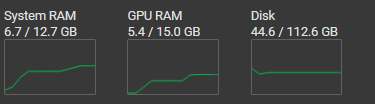

In [ ]:
for index,prompt in enumerate(dataset):
  print("\n------------------")
  print(f"Prompt numero: {index+1}")
  print("------------------")

  #FULL RESPONSE
  response, tokens_full_response, perplexity_full_response, end_start= first_generate(prompt=prompt, max_new_tokens=800)
  dataset_dict_truncated[f"model {index+1}"]={"timer":round(end_start,2),"tokens":tokens_full_response, "perplexity": perplexity_full_response}

In [ ]:
print(dataset_dict_truncated)
plot_status(dataset_dict_truncated)

Metto si se nella risposta è contenuto il risultato corretto anche se non ha finito il ragionamento.

1.   'timer': 47.84, 'tokens': 801, 'perplexity': 1.4391595125198364 NO
2.   'timer': 57.82, 'tokens': 801, 'perplexity': 1.399444341659546 NO
3.   'timer': 49.39, 'tokens': 801, 'perplexity': 1.3434993028640747 SI
4.   'timer': 49.73, 'tokens': 801, 'perplexity': 1.5368067026138306 SI
5.   'timer': 48.61, 'tokens': 801, 'perplexity': 1.4663958549499512 SI
6.   'timer': 49.16, 'tokens': 801, 'perplexity': 1.3322372436523438 NO
7.   'timer': 51.23, 'tokens': 801, 'perplexity': 1.5367507934570312 NO
8.   'timer': 60.93, 'tokens': 801, 'perplexity': 1.4563145637512207 NO
9.   'timer': 48.94, 'tokens': 801, 'perplexity': 1.5190557241439824 NO
10.  'timer': 48.31, 'tokens': 801, 'perplexity': 1.6290007829666138 NO



1.   'timer': 103.73, 'tokens': 1384, 'perplexity': 1.2949624061584473
2.   'timer': 96.21, 'tokens': 1604, 'perplexity': 1.2677875757217407
3.   'timer': 74.3, 'tokens': 1305, 'perplexity': 1.2395210266113281
4.   'timer': 70.92, 'tokens': 1232, 'perplexity': 1.3447023630142212
5.   'timer': 178.99, 'tokens': 3266, 'perplexity': 1.34502375125885
6.   'timer': 184.45, 'tokens': 3377, 'perplexity': 1.2622299194335938
7.   'timer': 360.02, 'tokens': 6483, 'perplexity': 1.413246750831604
8.   'timer': 138.05, 'tokens': 1900, 'perplexity': 1.244814395904541
9.   'timer': 189.71, 'tokens': 3206, 'perplexity': 1.3142908811569214 -2πi
10.   'timer': 150.69, 'tokens': 2418, 'perplexity': 1.3643732070922852 - infinity


In [ ]:
def validate(prompt, iter, model = model, summarizer = summarizer, max_tokens_response = 10, max_tokens_summary = 10):
  start= t.time()
  iter_counter= {}
  for i in range(1,iter+1):
    print("\n------------------")
    print("\n>>>>>>>>>>>>>>>>>>>>>>>>> Inizio iterazione: ", i, "<<<<<<<<<<<<<<<<<<<<<<<<<")
    print("------------------\n")

    if i==1:
      print("Response: ")
      timer, response, counter, perplexity = model.n_generate(prompt = prompt, summary = "", max_new_tokens = max_tokens_response)
      print("--------------")
      print("Counter: ", counter)
      iter_counter[f"iteration {i}"]={"tokens": counter, "perplexity" : perplexity}

    else:
      print("Summary:")
      print("------------------")
      summary, counter = summarizer.summarize(summarizer.truncated(response, n_tokens=200), max_new_tokens=max_tokens_summary)
      print("Counter: ", counter)
      iter_counter[f"iteration {i}"]=counter

      print("\n------------------")
      print("Response:")
      print("------------------")
      timer, response, counter, perplexity = model.n_generate(prompt=prompt, summary=summary, max_new_tokens=max_tokens_response)
      print("Counter: ", counter)
      iter_counter[f"Iteration {i}"]= {"tokens" : counter, "perplexity" : perplexity}
  end= t.time()
  return end-start, iter_counter

# Roba vecchia

In [ ]:
for index,prompt in enumerate(dataset):
  print("\n------------------")
  print(f"Prompt numero: {index+1}")
  print("------------------")

  # FULL RESPONSE
  response, tokens_full_response, perplexity_full_response, end_start= first_generate(prompt=prompt)
  dataset_dict[f"model {index+1}"]={"timer":round(end_start,2),"tokens":tokens_full_response, "perplexity": perplexity_full_response}
  print(dataset_dict)

  print("\n------------------")
  print("Starting validation")
  print("------------------")

  # START ITERATIONS
  perplexity= np.inf
  iter=1
  summary=""
  model, tokenizer = initialize_model(model_name, quantization_config, device)

  while not np.isclose(perplexity_full_response, perplexity, 0.01):

    # Ensure iter_dataset_dict[f"model {index}"] is a dictionary
    if f"model {index}" not in iter_dataset_dict or not isinstance(iter_dataset_dict[f"model {index}"], dict):
      iter_dataset_dict[f"model {index}"] = {} # Initialize as a dictionary if it's not or if it's not a dictionary

    print("\n------------------")
    print("Text: ")
    print("------------------")

    time, response, counter, perplexity= next_generation(prompt=prompt, summary=summary, model=model, tokenizer=tokenizer ,max_new_tokens=500)
    iter_dataset_dict[f"model {index}"][f"Iterazione {iter}"]={"timer": time,"counter": counter, "perplexity": perplexity} # Use iter instead of index for the iteration key


    print("\n------------------")
    print(f"Perplexity: {perplexity}: , Iteration: {iter}")
    print("------------------")

    print("\n------------------")
    print("Summary: ")
    print("------------------")

    summary, _ = summarization(truncated(response, n_tokens=400), max_new_tokens=200)
    iter+=1

  forget_all(model=model, tokenizer=tokenizer)

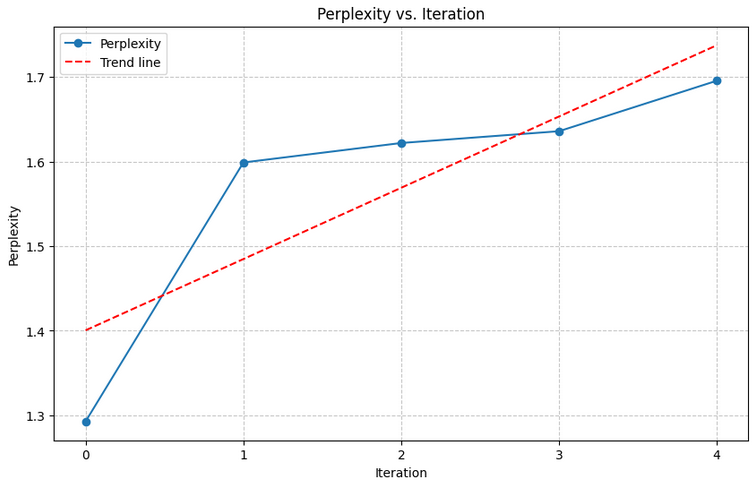

In [ ]:
print(iter_dataset_dict)

In [ ]:
def validate(prompt,iter, max_tokens_response=400, max_tokens_summary=150):
  start= t.time()
  iter_counter= {}
  for i in range(1,iter+1):
    print("\n------------------")
    print("Inizio iterazione: ", i)
    print("------------------\n")

    if i==1:
      print("Response: ")
      response, counter, perplexity = n_generate(prompt=prompt,summary="", max_new_tokens=max_tokens_response)
      print("--------------")
      print("Counter: ", counter)
      iter_counter[f"iteration {i}"]={"tokens": counter, "perplexity" : perplexity}

    else:
      print("Summary:")
      print("------------------")
      summary, counter = summarization(truncated(response, n_tokens=200), max_new_tokens=max_tokens_summary)
      print("Counter: ", counter)
      iter_counter[f"iteration {i}"]=counter

      print("\n------------------")
      print("Response:")
      print("------------------")
      response, counter, perplexity = n_generate(prompt=prompt, summary=summary, max_new_tokens=max_tokens_response)
      print("Counter: ", counter)
      iter_counter[f"Iteration {i}"]= {"tokens" : counter, "perplexity" : perplexity}
  end= t.time()
  return end-start, iter_counter

In [ ]:
validate("\int t^3-\frac{e^{-t}-4}{e^{-t}} dt", 4)

In [ ]:
validate("Solve this differential equation y′ − 2y = 1", 10, max_tokens_response=350, max_tokens_summary=150)

In [ ]:
validate("Solve this differential equation y′ + y = e^x", 10, max_tokens_response=350, max_tokens_summary=150)

In [ ]:
validate("Find the slope of the secant line between the values x1 and x2 of f(x)=4x+7;x1=2,x2=5",5, max_tokens_summary=150, max_tokens_response=350)